<a href="https://colab.research.google.com/github/russodanielp/intro_cheminformatics/blob/google_colab/Lab%2008%20-%20Machine%20Learning%20-%20Supervised%2C%20QSAR/colab_completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QSAR

## Aim of this lab

To use different machine learning alogorithms for Quantitative Structure Activity Relationship Modeling. 

### Objectives

* Use a variety of machine learning algorithms to develop QSAR models


## Background


Quantitative Structure-Activity Relationahsip (QSAR) modeling is one of the most common and useful methodologies in cheminformatics.  QSAR seeks to use machine learning algorithms to map chemical information to a biological activity.  The models can then be used for predictive purposes.

## Data:

__You'll have to do similar procedures for data__

Took from PubChem AID [743079](https://pubchem.ncbi.nlm.nih.gov/bioassay/743079#section=Result-Definitions)

Go to download data table.

You'll need to find the end points of interest (Activity Outcome, AC50, etc.).  They vary by assay.  

### Classification:

-Used PubChem `PUBCHEM_ACTIVITY_OUTCOME`. 
-Removed Records with no SMILES/CID.
-Removed Records with Inconclusive.  
-Balance Active Responses with Inactive response (more on this next lecture).  
-Made a new columns with a 1 if the chemical was Active 0 if it was Inactive 

### Regression:
-Used Column `Fit_LogAC50-Replicate_2` (you would ideally do all replicates and average results).   
-Only Used `Active` Chemicals.   

In [55]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
import pandas as pd
from rdkit.Chem import PandasTools

classification = pd.read_excel('AID_743079.xlsx', sheet_name='Classification')

classification.head()

,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,Activity
0,243,C1=CC=C(C=C1)C(=O)O,Active,1
1,299,C1(=O)C2(C3(C4(C1(C5(C2(C3(C(C45Cl)(Cl)Cl)Cl)C...,Active,1
2,299,C1(=O)C2(C3(C4(C1(C5(C2(C3(C(C45Cl)(Cl)Cl)Cl)C...,Active,1
3,323,C1=CC=C2C(=C1)C=CC(=O)O2,Active,1
4,325,CC(C)C1=CC=C(C=C1)CO,Active,1


In [57]:
PandasTools.AddMoleculeColumnToFrame(classification, smilesCol="PUBCHEM_EXT_DATASOURCE_SMILES")

In [58]:
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors


def calc_fp_from_mol(mol, method="maccs", n_bits=2048):
    """
    Encode a molecule from a RDKit Mol into a fingerprint.

    Parameters
    ----------
    mol : RDKit Mol
        The RDKit molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    if method == "maccs":
        return list(MACCSkeys.GenMACCSKeys(mol))
    elif method == "ecfp4":
        return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    elif method == "ecfp6":
        return list(AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return list(MACCSkeys.GenMACCSKeys(mol))

In [59]:
maccs_list = []

for mol in classification.ROMol.tolist():
    maccs = calc_fp_from_mol(mol, method="maccs")
    maccs_list.append(maccs)

maccs = pd.DataFrame(maccs_list)
print("There are", maccs.shape[1],"MACCS fingerprints")
maccs.head()

There are 167 MACCS fingerprints


,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,1,1,1,0


#### QSAR Modeling

Machine learning (ML)
ML text is adapted from the `sckit-learn` documentation [here](https://scikit-learn.org/stable/).  More information about the algorithms can be found on thier respective documentation pages. 

Classification: Identify which category an object belongs to (e.g. Active/Inactive bioassay respones, Toxic/non-toxic in humans)  
Regression: Prediction of a continuous-values attribute associated with an object (e.g., $\mu$m, AC$_50$ respones in bioassays)

A learning algorithm creates rules by finding patterns in the training data.

* Random Forest (RF): Ensemble of decision trees. A single decision tree splits the features of the input vector in a way that maximizes an objective function. In the random forest algorithm, the trees that are grown are de-correlated because the choice of features for the splits are chosen randomly.
* k-Nearest Neighbors (kNNs): A kNN predicts from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors found in the training set.

Most algorithms can be used as both classiers and regressors, however, there are certain algorithms that are not.  The two mentioned above that we will use in this lab are applicable for both.  Scikit-learn has seperate modules for classification and regression.  Therefore, if we want to use RF for classification, we have to import it a seperate object from RF for regression. 

To simulate "real-world" scenarios and to ensures your models are not overfit it is best practice to seperate the compounds being used for QSAR into __training__, and __test__ sets.  Training sets are used for tuning the model parameters and finding patterns usually through cross validation, which we will go over next lab and will ignore this time.  The test set is then used to evaluate the model's accuracy at predicting "new" or "unseen" data. __Test Set Data is the MOST important model validation data__

## Clasification

#### Data Preperation

First we split the data into training and set sets (a portain of the training set will be used as a validation set later).  Typically the QSAR table will consists of an `X` matrix consisting of predictor variables, which in our cases are molecular descriptors and is of the shape (N, M), where N is the number of compounds and M is the number of descriptors.  The second matix `y`,  consits of the values to be predicted, e.g., the classifications of bioassay calls or AC$_{50}$ values, in the case of classification and regression, respectively.  

First we prepare these two matrices.  

In [60]:
X = maccs.copy()
y = classification['Activity'].astype(int)

print(X.shape)
print(y.shape)

(2035, 167)
(2035,)


It is usually good practice to summarize/check/visualize the data in which you are trying to learn. 

In [61]:
y.value_counts()

0    1018
1    1017
Name: Activity, dtype: int64

#### Classification

The `train_test_split` function from `scikitlearn` splits our data to a provide test set size.  Here, we'll leave out 20% of our compounds as a test set.  

In [62]:
from sklearn.model_selection import KFold, train_test_split
SEED = 2008

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

Get the algorithms from `scikit-learn`.

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# RF
model_RF = RandomForestClassifier(n_estimators=200)

#knn
model_KNN = KNeighborsClassifier(n_neighbors=3, metric='jaccard')

### Train the models

Use the training data to fit the models

In [64]:
from sklearn.metrics import accuracy_score, confusion_matrix


model_RF.fit(X_train, y_train)
predicted_y = model_RF.predict(X_test)

In [65]:
accuracy_score(y_test, predicted_y)

0.8083538083538083

In [66]:
tn, fp, fn, tp = confusion_matrix(y_test, predicted_y).ravel()


ppv = tp/(tp+fp)
sens = tp/(tp+fn)

print(ppv, sens)

0.8457446808510638 0.7644230769230769


In [67]:
model_KNN.fit(X_train, y_train)
predicted_y = model_KNN.predict(X_test)
accuracy_score(y_test, predicted_y)

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


0.7714987714987716

#### Regression

For regression, we can use the same approach, but we need to change our `y` training vector to be the true continious values. 

Most of the algorithms in `sckit-learn` have both a `Classifer` and a `Regressor` interface.  Here we'll import the `Regressors`.

In [68]:
import pandas as pd
from rdkit.Chem import PandasTools

regression = pd.read_excel('AID_743079.xlsx', sheet_name='Regression')

regression.head()

,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,Fit_LogAC50-Replicate_2
0,6231,C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@]2(C#C)O)CCC4...,-9.3447
1,5281576,C[C@H]1CCCC(=O)CCC/C=C/C2=C(C(=CC(=C2)O)O)C(=O)O1,-9.2494
2,5991,C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@]2(C#C)O)CCC4...,-9.2168
3,5756,C[C@]12CC[C@H]3[C@H]([C@@H]1C[C@H]([C@@H]2O)O)...,-9.0751
4,5870,C[C@]12CC[C@H]3[C@H]([C@@H]1CCC2=O)CCC4=C3C=CC...,-9.0751


In [69]:
PandasTools.AddMoleculeColumnToFrame(regression, smilesCol="PUBCHEM_EXT_DATASOURCE_SMILES")

In [70]:
maccs_list = []

for mol in regression.ROMol.tolist():
    maccs = calc_fp_from_mol(mol, method="maccs")
    maccs_list.append(maccs)

maccs = pd.DataFrame(maccs_list)
print("There are", maccs.shape[1],"MACCS fingerprints")
maccs.head()

There are 167 MACCS fingerprints


,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0


In [71]:
X = maccs.copy()
y = regression['Fit_LogAC50-Replicate_2'].astype(float)

print(X.shape)
print(y.shape)

(976, 167)
(976,)


It is usually good practice to visualize the data in which you are trying to learn. 

<Axes: >

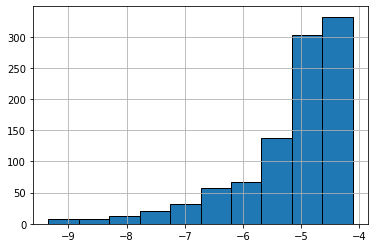

In [72]:
y.hist(bins=10, edgecolor='k')

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [74]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor


# RF
model_RF = RandomForestRegressor(n_estimators=100)

#knn
model_KNN = KNeighborsRegressor(n_neighbors=3, metric='jaccard')

The metrics used to evaluate classication models are not the same as those used for evaluating regression models.  Typically, there are two metrics __r$^2$__ and the __mean absolute error (MAE)__.

In [75]:
from sklearn.metrics import mean_absolute_error, r2_score

model_RF.fit(X_train, y_train)
predicted_y = model_RF.predict(X_test)
mae = mean_absolute_error(y_test, predicted_y)
r2 = r2_score(y_test, predicted_y)

mae, r2

(0.5346069262569205, 0.374044997209652)

In [76]:
model_KNN.fit(X_train, y_train)
predicted_y = model_KNN.predict(X_test)
mae = mean_absolute_error(y_test, predicted_y)
r2 = r2_score(y_test, predicted_y)

mae, r2

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


(0.5792578231292517, 0.3267338017252831)